In [0]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import random


from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist

from ipywidgets import interactive
from collections import defaultdict
from collections import Counter
from random import randint

!pip install hdbscan
import hdbscan
import folium
import re



cols = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(200)]


     |████████████████████████████████| 4.7MB 26kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2361294 sha256=633b686aca0d73f3edc13414dbab7a8db4ece6c9bdcabfe4ca635d485d065b49
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [0]:
df = pd.read_excel('COVID-19(1).xlsx')
df1 = pd.read_excel('covid19.xlsx') # modified dataset for dbscan and hdbscan



In [0]:
df.columns = [c.replace(' ', '') for c in df.columns]
df1.columns = [c.replace(' ', '') for c in df1.columns]

df.head()

,NameofDistrict,Longitude,Latitude,Numberofpeopleaffected
0,ANDAMAN,92.6586,11.7401,10
1,ANANTAPUR,77.6006,14.6819,2
2,CHITTOOR,79.1003,13.2172,10
3,EAST GODAVARI,82.0407,17.3213,11
4,GUNTUR,80.4365,16.3067,30


In [0]:
x = df[['Numberofpeopleaffected']].values.astype(float)
x1 = df1[['Numberofpeopleaffected']].values.astype(float)


# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,5))

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)
x1_scaled = min_max_scaler.fit_transform(x1)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df1_normalized = pd.DataFrame(x1_scaled)


df['Numberofpeopleaffected'] = df_normalized
df1['Numberofpeopleaffected'] = df1_normalized




df.head()






,NameofDistrict,Longitude,Latitude,Numberofpeopleaffected
0,ANDAMAN,92.6586,11.7401,1.112853
1,ANANTAPUR,77.6006,14.6819,1.012539
2,CHITTOOR,79.1003,13.2172,1.112853
3,EAST GODAVARI,82.0407,17.3213,1.125392
4,GUNTUR,80.4365,16.3067,1.363636


In [0]:
df.describe()

,Longitude,Latitude,Numberofpeopleaffected
count,275.000000,275.000000,275.000000
mean,78.864603,21.839669,1.147826
std,4.982659,6.966649,0.381936
min,69.629300,8.088300,1.000000
25%,75.792400,16.552000,1.012539
50%,77.607800,22.616800,1.050157
75%,79.986450,27.603750,1.150470
max,96.173900,34.553900,5.000000


In [0]:
df.duplicated(subset = ['Longitude' , 'Latitude']).values.any()

False

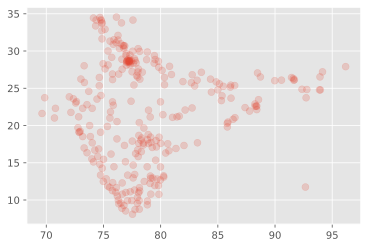

In [0]:
X = np.array(df[['Longitude' , 'Latitude']], dtype = 'float64')
plt.scatter(X[:,0], X[:,1], alpha = 0.2, s=50)

In [0]:
#Visual Representation of Data
m = folium.Map(location=[df.Latitude.mean()+5,df.Longitude.mean()], zoom_start=5)

for _, row in df.iterrows():
  folium.CircleMarker(
      location = [row.Latitude, row.Longitude],
      radius = row.Numberofpeopleaffected,
      popup = row[0],
      color='crimson',
      fill=True,
      fill_color='crimson'
      ).add_to(m)

m      
      


In [0]:
#Elbow method through distortions 

X = np.array(df[['Longitude' , 'Latitude']].astype(float))
Y = np.array(df['Numberofpeopleaffected'].astype(float))

distortions = [] 
mapping1 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    #kmeanModel = KMeans(n_clusters=k).fit(X) 
    #kmeanModel.fit(X)

    model = KMeans(n_clusters = k, random_state = 17)
    model.fit(X, sample_weight=Y)     
      
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  
    mapping1[k] = sum(np.min(cdist(X, model.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 

1 : 7.925629810526729
2 : 5.184264096734359
3 : 3.7901271283169153
4 : 3.0977224802298795
5 : 2.7076294772098515
6 : 2.4871112177345025
7 : 2.2085544974393225
8 : 2.0269862646045653
9 : 1.889338140667657
10 : 1.7824447891612494
11 : 1.7376777678887219
12 : 1.640157473210391
13 : 1.561986575251512
14 : 1.472583685680929
15 : 1.4237047790554456
16 : 1.382882636415833
17 : 1.3084666346213967
18 : 1.2824499310429793
19 : 1.196832833512958


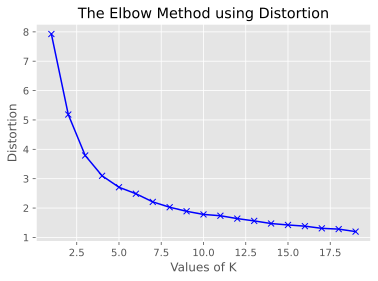

In [0]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

# Distortions may not be the best method to calculate a approx value of K

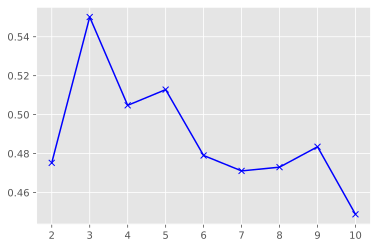

In [0]:
#Elbow method through Silhouette Score

sil = []
kmax = 10
K=range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in K:
    model = KMeans(n_clusters = k, random_state = 17)
    model.fit(X, sample_weight=Y)
    labels = model.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(K,sil,'bx-')

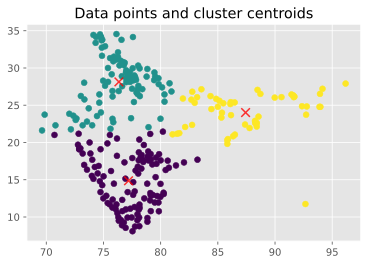

In [0]:
#Kmeans
X = np.array(df[['Longitude' , 'Latitude']].astype(float))
Y = np.array(df['Numberofpeopleaffected'].astype(float))

k = 3
model = KMeans(n_clusters = k, random_state = 17)
wt_kmeans = model.fit(X, sample_weight=Y)
predicted_kmeans = model.predict(X, sample_weight = Y)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

plt.scatter(X[:, 0], X[:, 1], c=class_predictions, cmap="viridis")


centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=75, alpha=0.8, marker='x') #displays centers of each clusters
plt.title('Data points and cluster centroids')
plt.show()




In [0]:
def create_map(df , cluster_column):
  m = folium.Map(location=[df.Latitude.mean(),df.Longitude.mean()], zoom_start=5 , tiles ='Stamen Toner')

  for _, row in df.iterrows():

    cluster_color = cols[int(row[cluster_column]%20)]
    folium.CircleMarker(
        location = [row.Latitude, row.Longitude],
        radius = row[3],
        color=cluster_color,
        fill=True,
        fill_color=cluster_color

    ).add_to(m)
  
  return m

m = create_map(df,'CLUSTER_kmeans3')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')


Silhouette Score: 0.5500922278898407


In [0]:
m

In [0]:
best_silhouette, best_k = -1,0
X = np.array(df[['Longitude' , 'Latitude']].astype(float))
Y = np.array(df['Numberofpeopleaffected'].astype(float))
for k in tqdm(range(2, 100))
:
  model = KMeans(n_clusters=k, random_state = 1).fit(X,sample_weight=Y)
  class_predictions = model.predict(X,sample_weight=Y)

  curr_silhouette = silhouette_score(X, class_predictions)
  if curr_silhouette > best_silhouette:
    best_k = k
    best_silhouette = curr_silhouette

print(f'K = {best_k}')
print(f'Silhouette Score : {best_silhouette}')


100%|██████████| 98/98 [00:24<00:00,  4.07it/s]

K = 3
Silhouette Score : 0.5500922278898407


In [0]:
#map function for dbscan and hdbscan. Use df1 from here onwards
X = np.array(df1[['Longitude' , 'Latitude']], dtype = 'float64')
def create_map1(df1 , cluster_column):
  m = folium.Map(location=[df1.Latitude.mean(),df1.Longitude.mean()], zoom_start=5 , tiles ='Stamen Toner')

  for _, row in df1.iterrows():

    cluster_color = cols[int(row[cluster_column])]
    folium.CircleMarker(
        location = [row.Latitude, row.Longitude],
        radius = row[3],
        color=cluster_color,
        fill=True,
        fill_color=cluster_color

    ).add_to(m)
  
  return m

In [0]:
#DBSCAN from scratch
def MyDBSCAN(D, eps, MinPts):
    
       
    labels = [0]*len(D)

    C = 0
    
    for P in range(0, len(D)):
    
       
        if not (labels[P] == 0):
           continue
        
        NeighborPts = regionQuery(D, P, eps)
        
        
        if len(NeighborPts) < MinPts:
            labels[P] = -1
         
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    return labels


def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
    
    labels[P] = C
    
    i = 0
    while i < len(NeighborPts):    
        
        Pn = NeighborPts[i]
       
        if labels[Pn] == -1:
           labels[Pn] = C
        
        elif labels[Pn] == 0:
            labels[Pn] = C
            
]            PnNeighborPts = regionQuery(D, Pn, eps)
            
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            
        i += 1        
    


def regionQuery(D, P, eps):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    for Pn in range(0, len(D)):
        
        if np.linalg.norm(D[P] - D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors






In [0]:
X = np.array(df1[['Longitude' , 'Latitude']], dtype = 'float64')
labels = MyDBSCAN(X,1,50)




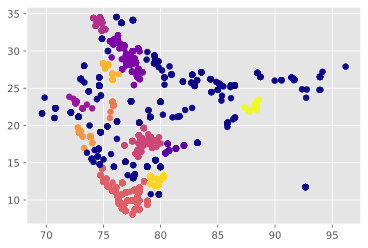

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="plasma")
df1['CLUSTER_DBSCAN'] = labels

In [0]:
df1.head()

,NameofDistrict,Longitude,Latitude,Numberofpeopleaffected,CLUSTER_DBSCAN
0,ANDAMAN,92.6586,11.7401,1.112853,-1
1,ANDAMAN,92.6586,11.7401,1.112853,-1
2,ANDAMAN,92.6586,11.7401,1.112853,-1
3,ANDAMAN,92.6586,11.7401,1.112853,-1
4,ANDAMAN,92.6586,11.7401,1.112853,-1


In [0]:
m=create_map1(df1,'CLUSTER_DBSCAN')
m

In [0]:
print(f'Number of cluster found: {len(np.unique(labels))-1}')

print(f'Silhouette Score:{silhouette_score(X,labels)}')


Number of cluster found: 11
Silhouette Score:0.4457571572417328


In [0]:
#Dbscan using library
X = np.array(df1[['Longitude' , 'Latitude']], dtype = 'float64')

model = DBSCAN(eps=1, min_samples=50).fit(X)
class_predictions = model.labels_


df1['CLUSTER_DBSCANlib'] = class_predictions

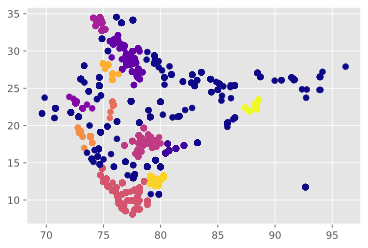

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=class_predictions, cmap="plasma")

In [0]:
m = create_map1(df1,'CLUSTER_DBSCANlib')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')

print(f'Silhouette score:{silhouette_score(X,class_predictions)}')

Number of clusters found: 12
Silhouette score:0.4457571572417328


In [0]:
m

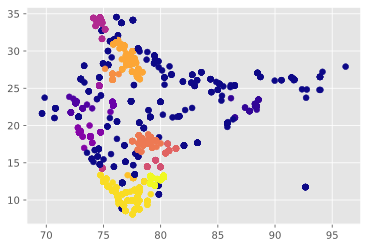

In [0]:
#Hdbscan
X = np.array(df1[['Longitude' , 'Latitude']].astype(float))

model = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=50,cluster_selection_epsilon=1)
class_predictions = model.fit_predict(X)
df1['CLUSTER_HDBSCAN'] = class_predictions

plt.scatter(X[:, 0], X[:, 1], c=class_predictions, cmap="plasma")



In [0]:
m = create_map(df1,'CLUSTER_HDBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhouette without outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter,x in enumerate(class_predictions)])
print(f'Silhouette score:{silhouette_score(X,no_outliers)}')

Number of clusters found: 15
Number of outliers found: 547
Silhouette without outliers: 0.6191331201790085
Silhouette score:0.27668655488562555


In [0]:
m

In [0]:
#Adressing outliers.
classifier = KNeighborsClassifier(n_neighbors=1)

In [0]:
df1_train = df1[df1.CLUSTER_HDBSCAN!=-1]
df1_predicted = df1[df1.CLUSTER_HDBSCAN==-1]

In [0]:
X_train = np.array(df1_train[['Latitude','Longitude']],dtype='float64')
Y_train = np.array(df1_train['CLUSTER_HDBSCAN'])
X_predict = np.array(df1_predicted[['Latitude','Longitude']],dtype='float64')

In [0]:
classifier.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
predictions = classifier.predict(X_predict)

In [0]:
df1['CLUSTER_hybrid'] = df1['CLUSTER_HDBSCAN']

In [0]:
df1.loc[df1.CLUSTER_HDBSCAN==-1,'CLUSTER_hybrid'] = predictions

In [0]:
m = create_map1(df1,'CLUSTER_hybrid')
m

In [0]:
class_predictions =  df1.CLUSTER_hybrid
print(f'Number of cluster found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

Number of cluster found: 15
Silhouette: 0.5174652361618018
